In [1]:
import os
import sys
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aqiGDL
%matplotlib inline

import datetime
import textwrap

/home/edgar/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [4]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
colors = ['7A76C2', 'ff6e9c98', 'f62196', '18c0c4', 'f3907e', '66E9EC']

In [5]:
gdf = aqiGDL.gdf_from_db('smartcitizen', 'public')
gdf

device_id                                              param unit  \
0           13483  Total Volatile Organic Compounds Digital Indoo...  ppb   
1           13483  Total Volatile Organic Compounds Digital Indoo...  ppb   
2           13483  Total Volatile Organic Compounds Digital Indoo...  ppb   
3           13483  Total Volatile Organic Compounds Digital Indoo...  ppb   
4           13483  Total Volatile Organic Compounds Digital Indoo...  ppb   
...           ...                                                ...  ...   
277281      13772                                        Temperature   ºC   
277282      13772                                        Temperature   ºC   
277283      13772                                        Temperature   ºC   
277284      13772                                        Temperature   ºC   
277285      13772                                        Temperature   ºC   

               lon        lat                  date         value  \
0      -103.351588  20.685147  2021-03-03T15:00:38Z  23628.451613   
1      -103.351588  20.685147  2021-03-03T14:00:08Z  29206.000000   
2      -103.351588  20.685147  2021-03-03T13:00:51Z  29206.000000   
3      -103.351588  20.685147  2021-03-03T12:00:49Z  29206.000000   
4      -103.351588  20.685147  2021-03-03T11:00:50Z  29206.000000   
...            ...        ...                   ...           ...   
277281 -103.413618  20.668877  2021-02-21T01:00:32Z     19.480167   
277282 -103.413618  20.668877  2021-02-21T00:00:26Z     19.575833   
277283 -103.413618  20.668877  2021-02-20T23:00:16Z     19.710333   
277284 -103.413618  20.668877  2021-02-20T22:00:12Z     19.777000   
277285 -103.413618  20.668877  2021-02-20T21:42:12Z     20.034444   

                              geometry  
0       POINT (671692.111 2288175.175)  
1       POINT (671692.111 2288175.175)  
2       POINT (671692.111 2288175.175)  
3       POINT (671692.111 2288175.175)  
4       POINT (671692.111 2288175.175)  
...                                ...  
277281  POINT (665247.641 2286309.678)  
277282  POINT (665247.641 2286309.678)  
277283  POINT (665247.641 2286309.678)  
277284  POINT (665247.641 2286309.678)  
277285  POINT (665247.641 2286309.678)  

[277286 rows x 8 columns]

In [5]:
G = ox.graph_from_bbox(20.7900,20.523110,-103.2400,-103.4700)
edges = ox.graph_to_gdfs(G, nodes=False)

In [6]:
gdf_est = gdf[['device_id','lon','lat']].groupby('device_id').mean()
gdf_est = gpd.GeoDataFrame(
    gdf_est, geometry=gpd.points_from_xy(gdf_est.lon, gdf_est.lat))
gdf_est.head(2)

lon        lat                     geometry
device_id                                                    
13483     -103.351588  20.685147  POINT (-103.35159 20.68515)
13492     -103.389891  20.651647  POINT (-103.38989 20.65165)

In [76]:
def graph_smartcitizen(device, param, gdf, gdf_est, edges, save=False):

    fig, axes = plt.subplots(1,2,figsize=(24,8), sharex=True)

    df_temp = gdf[(gdf['device_id']==device) & (gdf['param']==param)].copy()
    df_temp['date'] = pd.to_datetime(df_temp['date'])
    df_temp.set_index('date',inplace=True)
    df_temp = df_temp.resample('D').mean()
    axes[1].scatter(df_temp.index, df_temp['value'], label=param)
    axes[1].plot(df_temp.index, df_temp['value'], '--', zorder=1, color='white', alpha=0.35)
    
    df_std = gdf[(gdf['device_id']==device) & (gdf['param']==param)].copy()
    df_std['date'] = pd.to_datetime(df_std['date'])
    df_std.set_index('date',inplace=True)
    df_std = df_std.resample('D').std()
    axes[1].errorbar(df_std.index, df_temp['value'], df_std['value'], linestyle='None', zorder=2, color='red', alpha=0.35)
    
    title = textwrap.fill(param, 35)
    axes[1].set_title(title,fontsize=20)
    axes[1].tick_params(axis='x',labelrotation=45)


    x_ticks = np.arange(0, len(df_temp.index),15)

    a00 = axes[0]
    shax = a00.get_shared_x_axes()
    shax.remove(a00)
    edges.plot(ax=axes[0], color='#e8e9eb',linewidth=0.1, zorder=-1)
    edges[(edges['highway']=='primary') | (edges['highway']=='secondary')].plot(ax=axes[0], color='#e8e9eb',linewidth=0.5, zorder=0)
    gdf_est.plot(ax=axes[0], color='k', alpha=0.85, zorder=1)
    gdf_est[gdf_est.index==device].plot(ax=axes[0], color='#ba0d38', alpha=0.85, zorder=2, markersize=90)
    axes[0].axis('off')
    estacion = device
    fecha_1 = df_temp.index.min().strftime("%Y-%m-%d")
    fecha_2 = df_temp.index.max().strftime("%Y-%m-%d")
    fig.suptitle(f'Device: {estacion}\n{fecha_1} -- {fecha_2}', fontsize=30)

    if save==True:
        plt.savefig(f'{device}_{fecha_1}_{fecha_2}.png',dpi=300)

    return plt.show()

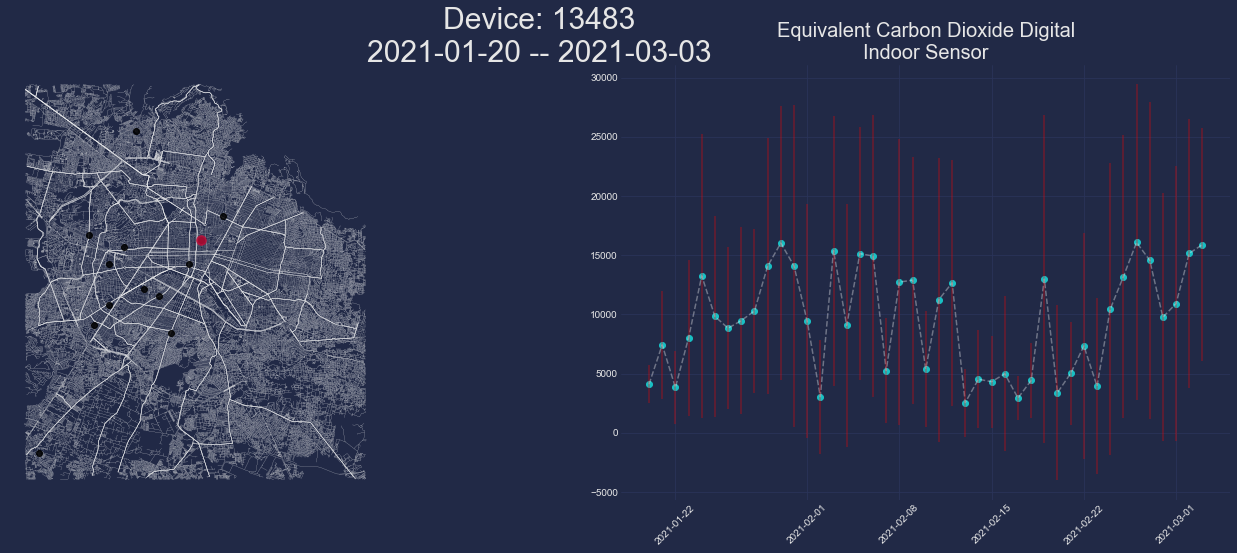

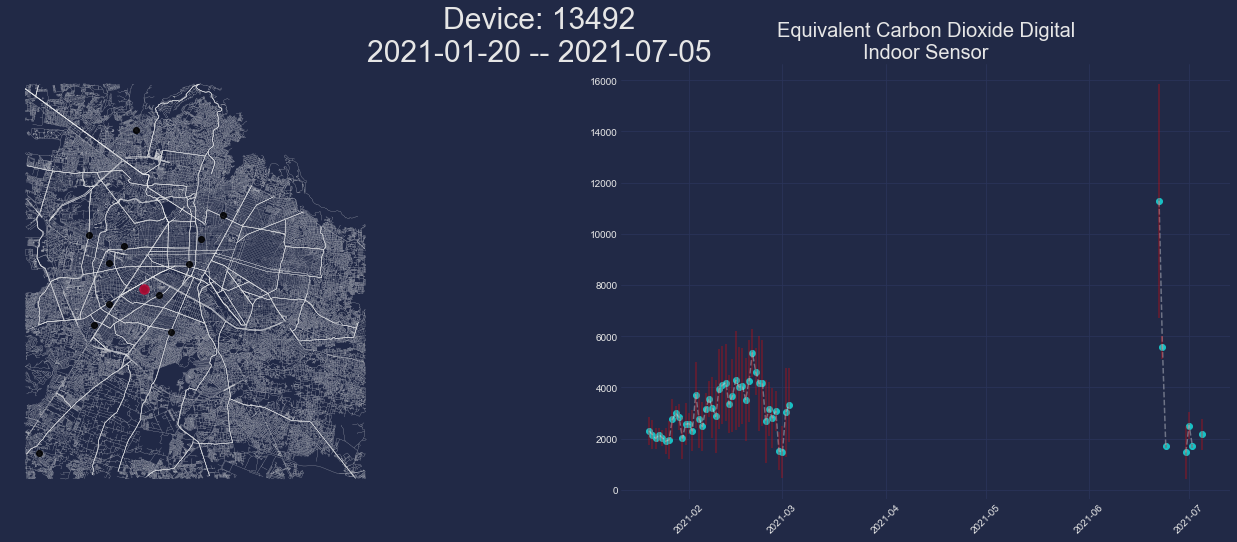

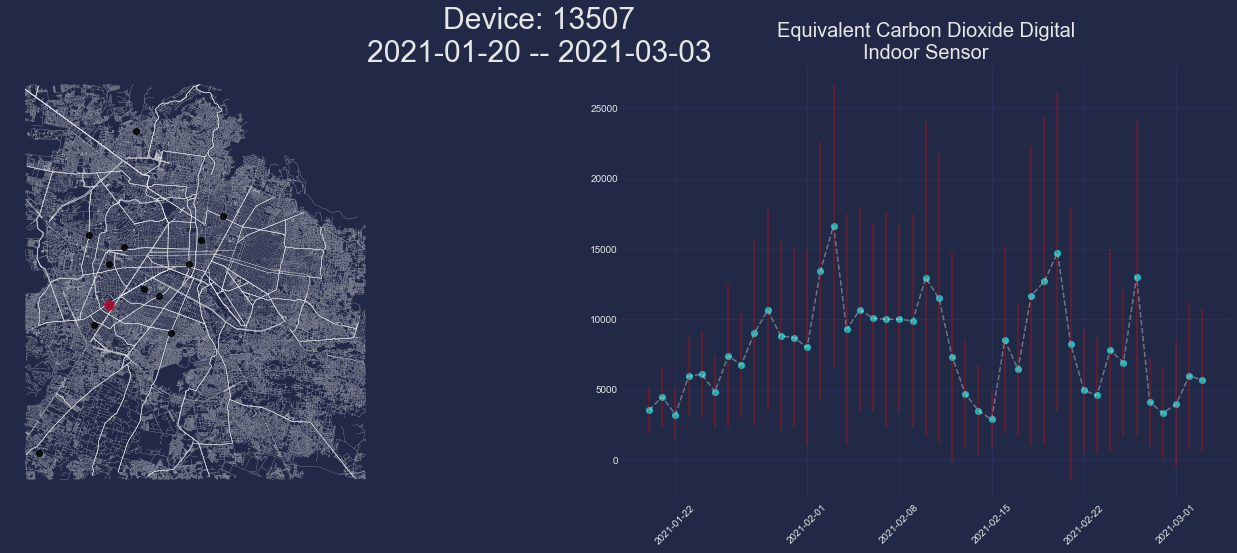

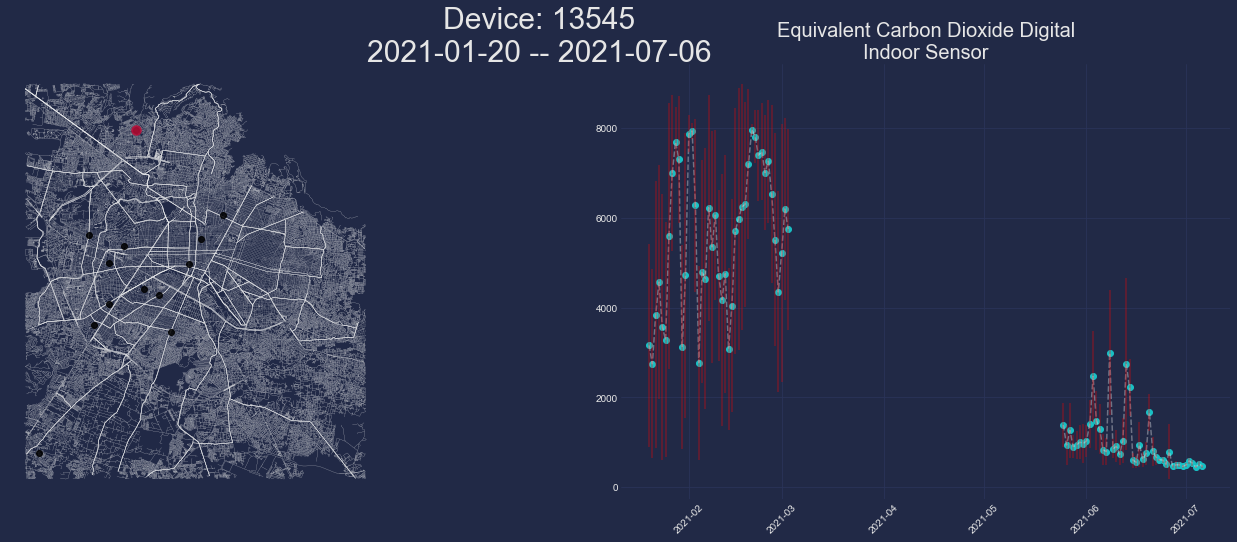

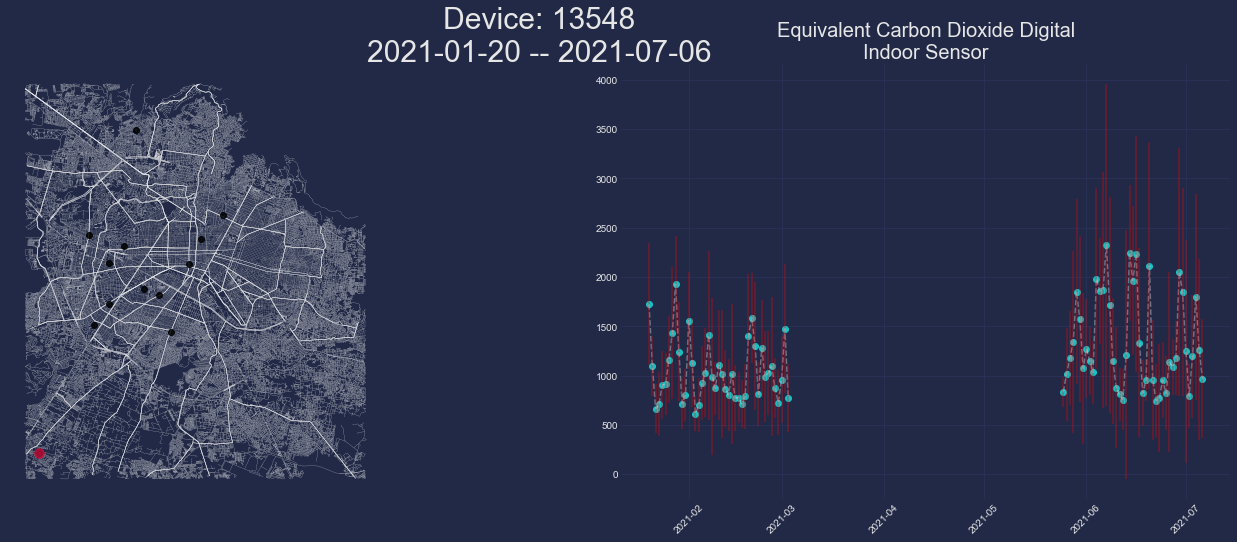

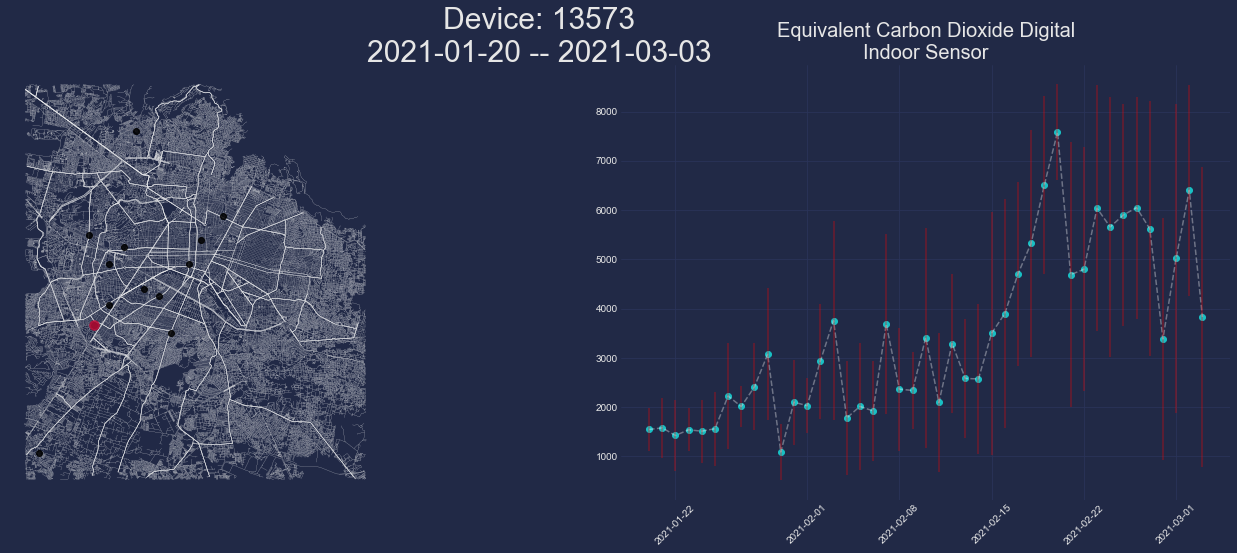

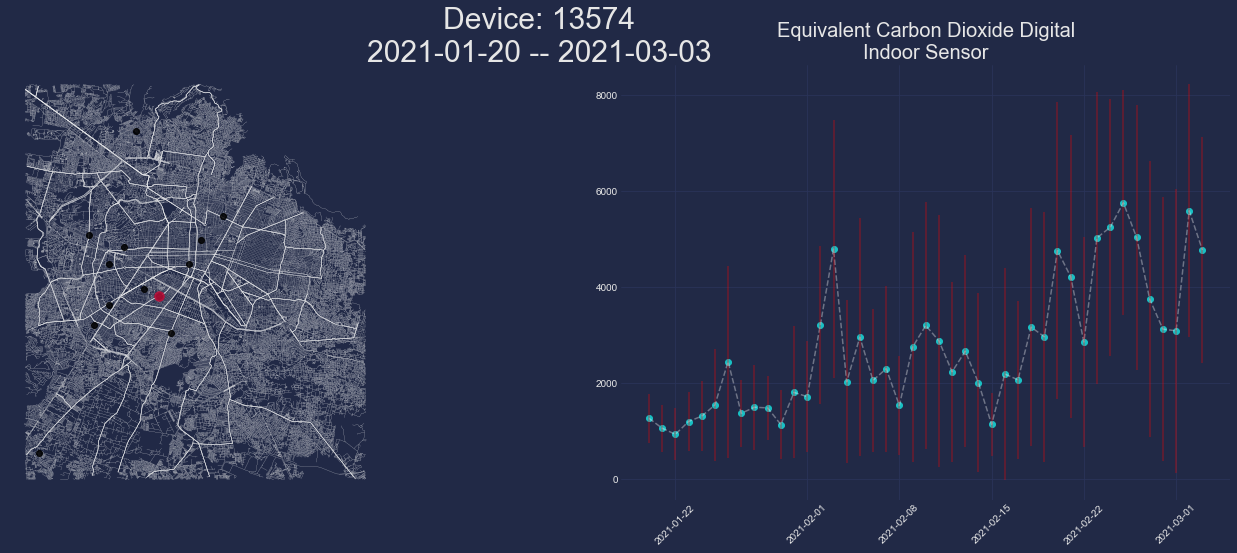

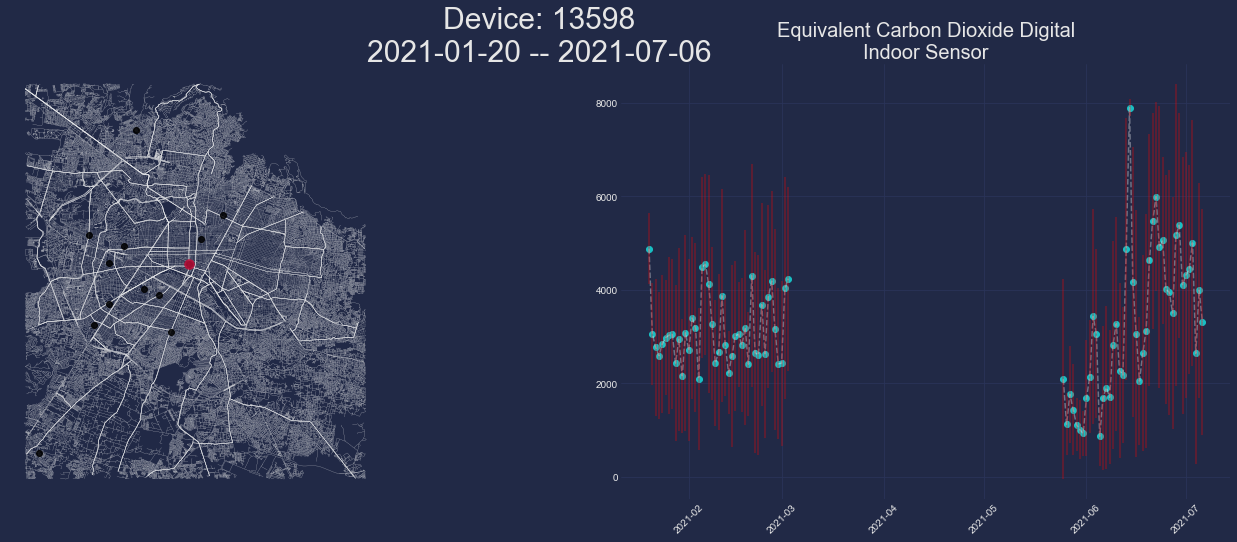

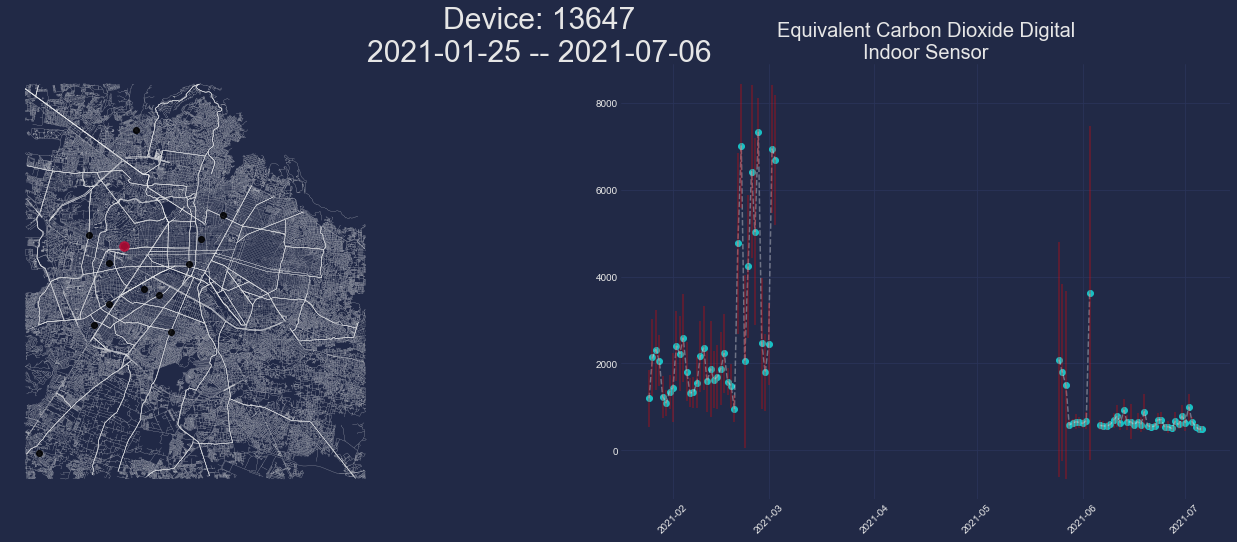

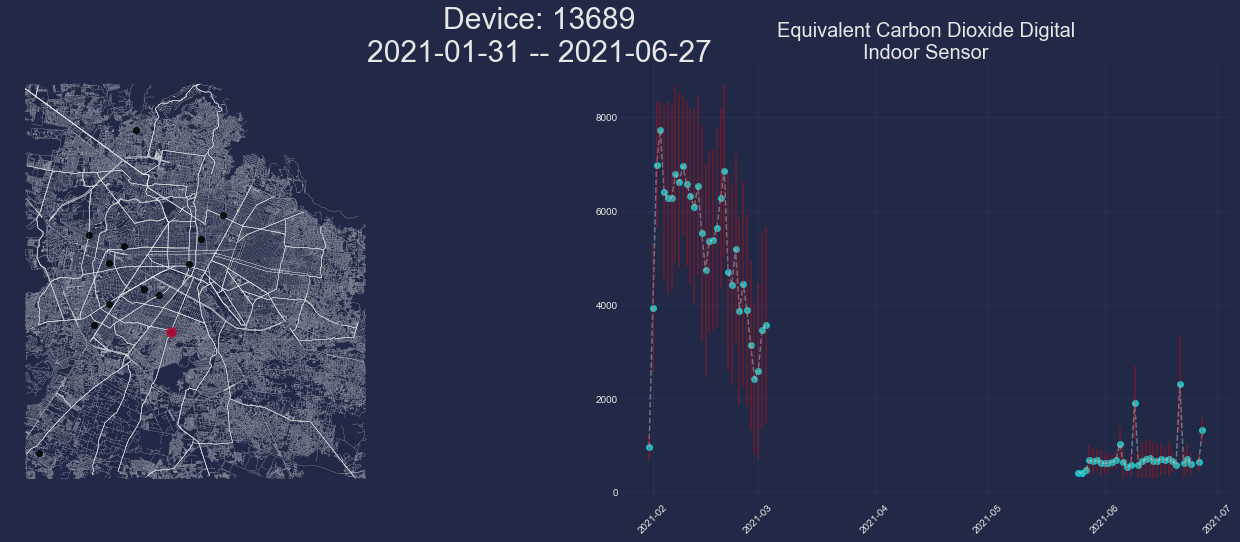

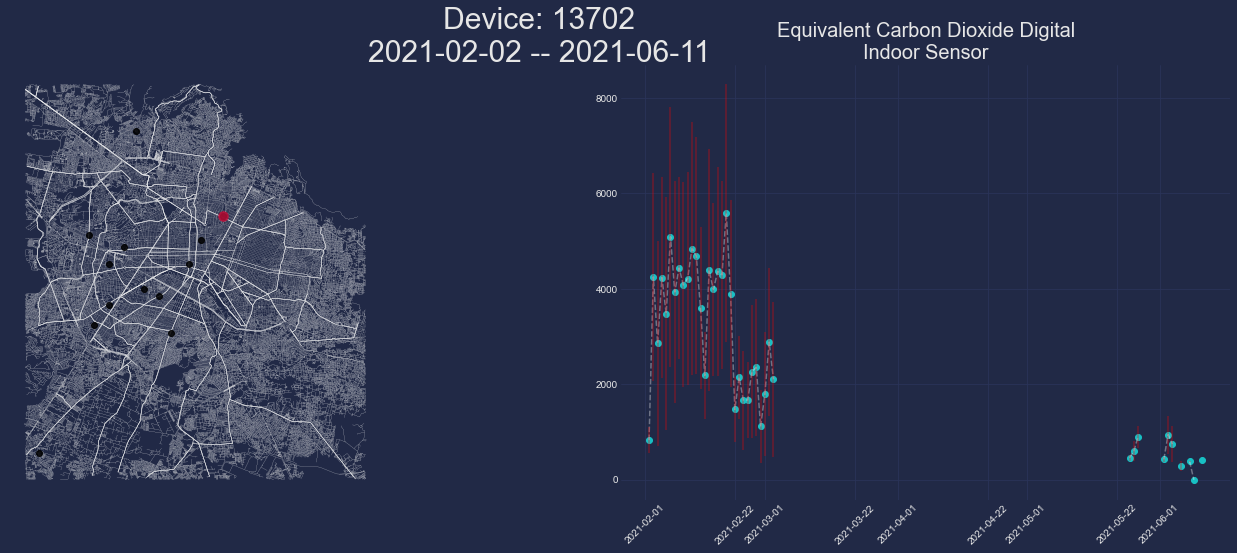

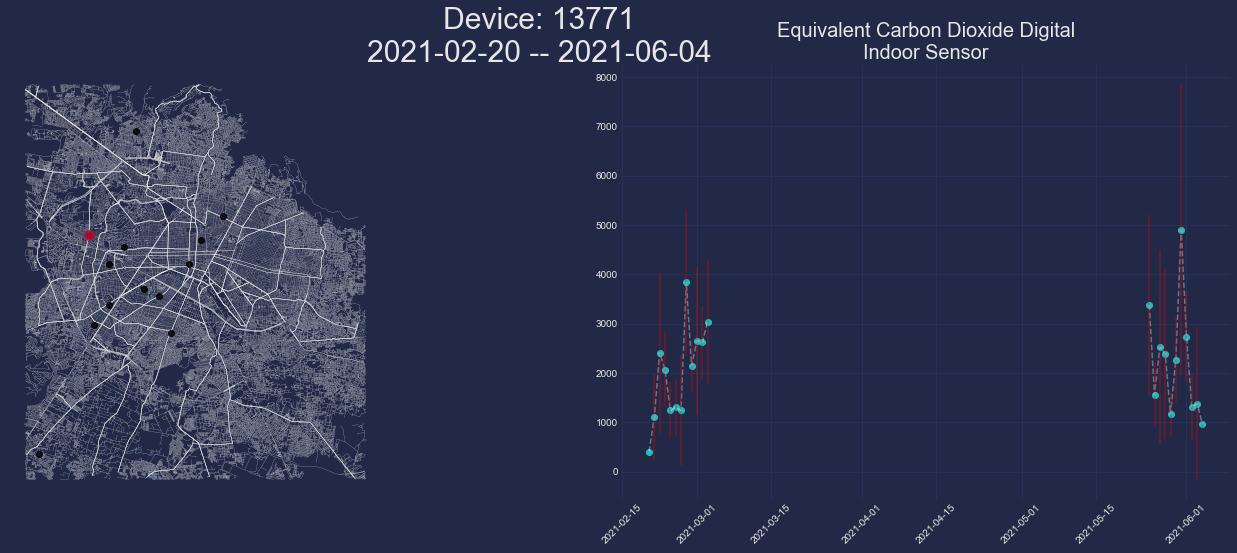

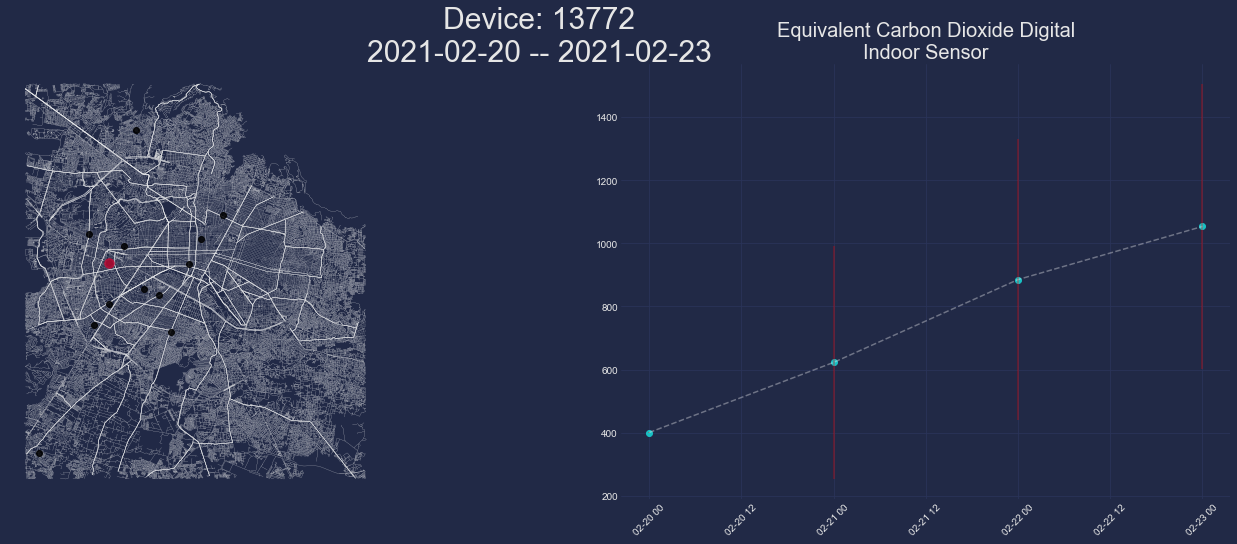

In [77]:
param = 'Equivalent Carbon Dioxide Digital Indoor Sensor'

for est in gdf.device_id.unique():
    
    graph_smartcitizen(est, param, gdf, gdf_est, edges, save=False)
    